In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import math

In [0]:
data=pd.read_csv('interview_dataset.csv',skiprows=[1])
data["datetime"]=pd.to_datetime(data["datetime"],errors='coerce')
data = data.set_index(['datetime'])

In [3]:
# Original Code
# Converts all USAGE_KWH values less than 5 into nans, which are replaced using linear interpolation- necessary for boxcox transform

weird = []
index = 0
for item in data.iloc[:,0]:
    index+=1
    if item>=0 and item<5:
        print(str(item)+" the index is " + str(index))
        weird.append(index-1)
for item in weird:
    data.iloc[item,0] = np.nan
    print(data.iloc[item,0])
    
data.iloc[:,0] = data.iloc[:,0].interpolate(method='linear')
print(sum(np.isnan(x) for x in data.iloc[:,0]))

1.133 the index is 17249
0.0 the index is 17250
0.0 the index is 17251
0.0 the index is 17252
0.0 the index is 17253
0.0 the index is 17254
0.0 the index is 17255
0.0 the index is 28778
0.0 the index is 28779
nan
nan
nan
nan
nan
nan
nan
nan
nan
0


In [4]:
# Original Code
for num in range(data.shape[1]):
    data.iloc[:,num] = data.iloc[:,num].interpolate(method='linear')
    print(sum(np.isnan(x) for x in data.iloc[:,num]))

0
0
0
0
0
0
0


In [0]:
# Code from https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

from pandas import DataFrame, concat
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

from sklearn.preprocessing import MinMaxScaler

# frame as supervised learning
reframed = series_to_supervised(data.values, 100, 96)
# drop columns we don't want to predict
no_pred = []
for out in range(96):
    for var in range(6):
        no_pred.append(701+var+out*7)
reframed.drop(reframed.columns[no_pred], axis=1, inplace=True)
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(reframed)

In [0]:
# Original Code
# split into train and test sets
values = scaled
n_train_hours = len(values)-96-100
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

In [10]:
# Code from https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

train_X, train_y = train[:, :-96], train[:, -96:]
test_X, test_y = test[:-96, :-96], test[:-96, -96:]

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(34744, 700) (34744, 96) (100, 700) (100, 96)


In [11]:
# Code from https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html
from sklearn import datasets, linear_model
from pandas import DataFrame, concat
from numpy import concatenate
from sklearn.metrics import mean_squared_error, r2_score


# Create linear regression object
regr = linear_model.LinearRegression()
regr.fit(train_X, train_y)
y_pred = regr.predict(test_X)

# Code from https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
# invert scaling for forecast
inv_yhat = concatenate((y_pred, test_X[:,-700:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,:96]
# invert scaling for actual
inv_y = concatenate((test_y, test_X[:, -700:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,:96]
# calculate MSE
mse = mean_squared_error(inv_y, inv_yhat)
print('Test MSE: %.3f' % mse)

# Code from https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html
# The coefficients
print('Coefficients: \n', regr.coef_)
'''# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_pred, test_y))'''
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(inv_y, inv_yhat))

Test MSE: 14.700
Coefficients: 
 [[-0.00279522  0.00085761 -0.11685949 ... -0.00851073  0.02256284
  -0.00167864]
 [-0.0052113   0.00118915  0.00113737 ...  0.01140166  0.01886775
  -0.00117592]
 [-0.01240601 -0.00255405  0.12746834 ...  0.0532605  -0.01096591
   0.00414164]
 ...
 [-0.08378159  0.00183905 -0.24921924 ...  0.10915373 -0.09998254
  -0.00700643]
 [-0.06122036  0.0018438  -0.10774692 ...  0.14759056 -0.12861362
  -0.00418247]
 [-0.04938372  0.00182468  0.11907477 ...  0.19358619 -0.16954102
  -0.00815204]]
Variance score: 0.13


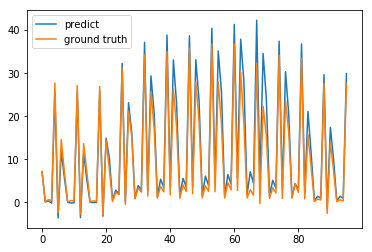

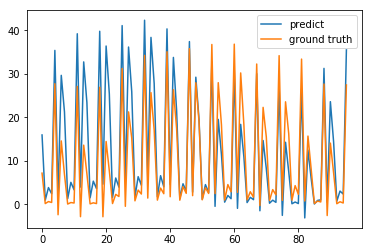

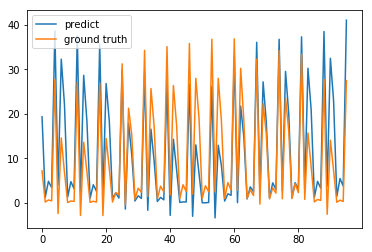

In [13]:
# Original Code
from matplotlib import pyplot

pyplot.figure()
pyplot.plot(inv_yhat[0,:], label='predict')
pyplot.plot(inv_y[0,:], label='ground truth')
pyplot.legend()
pyplot.show()

pyplot.figure()
pyplot.plot(inv_yhat[30,:], label='predict')
pyplot.plot(inv_y[0,:], label='ground truth')
pyplot.legend()
pyplot.show()

pyplot.figure()
pyplot.plot(inv_yhat[60,:], label='predict')
pyplot.plot(inv_y[0,:], label='ground truth')
pyplot.legend()
pyplot.show()

In [20]:
# Code from https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/
import pickle
# save the model to disk
filename = 'linear_regression.sav'
pickle.dump(regr, open(filename, 'wb'))

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
y_pred = loaded_model.predict(test_X)

# Code from https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
# invert scaling for forecast
inv_yhat = concatenate((y_pred, test_X[:,-700:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,:96]
# invert scaling for actual
inv_y = concatenate((test_y, test_X[:, -700:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,:96]
# calculate MSE
mse = mean_squared_error(inv_y, inv_yhat)
print('Test MSE: %.3f' % mse)

Test MSE: 14.700


In [0]:
# Code from https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

regr = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=100)
regr.fit(train_X, train_y)  
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=0, verbose=1, warm_start=False)
predictions = regr.predict(test_X)

In [22]:
# Code from https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
# invert scaling for forecast
inv_yhat = concatenate((predictions, test_X[:,-700:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,:96]
# invert scaling for actual
inv_y = concatenate((test_y, test_X[:, -700:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,:96]
# calculate MSE
mse = mean_squared_error(inv_y, inv_yhat)
print('Test MSE: %.3f' % mse)

Test MSE: 20.071


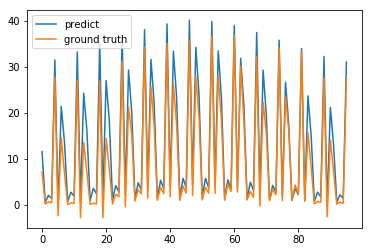

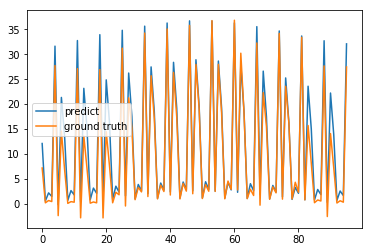

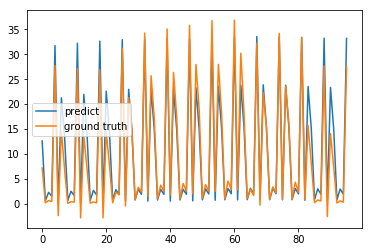

In [23]:
# Original Code
from matplotlib import pyplot

pyplot.figure()
pyplot.plot(inv_yhat[0,:], label='predict')
pyplot.plot(inv_y[0,:], label='ground truth')
pyplot.legend()
pyplot.show()

pyplot.figure()
pyplot.plot(inv_yhat[30,:], label='predict')
pyplot.plot(inv_y[0,:], label='ground truth')
pyplot.legend()
pyplot.show()

pyplot.figure()
pyplot.plot(inv_yhat[60,:], label='predict')
pyplot.plot(inv_y[0,:], label='ground truth')
pyplot.legend()
pyplot.show()

In [24]:
# Code from https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/
import pickle
# save the model to disk
filename = 'random_forest_regressor.sav'
pickle.dump(regr, open(filename, 'wb'))

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
y_pred = loaded_model.predict(test_X)

# Code from https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
# invert scaling for forecast
inv_yhat = concatenate((y_pred, test_X[:,-700:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,:96]
# invert scaling for actual
inv_y = concatenate((test_y, test_X[:, -700:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,:96]
# calculate MSE
mse = mean_squared_error(inv_y, inv_yhat)
print('Test MSE: %.3f' % mse)

Test MSE: 20.071
